# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline


### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [2]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('adult.csv')



data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

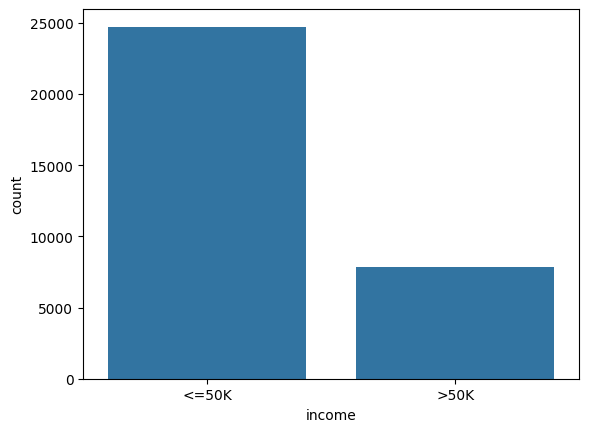

In [5]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [7]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

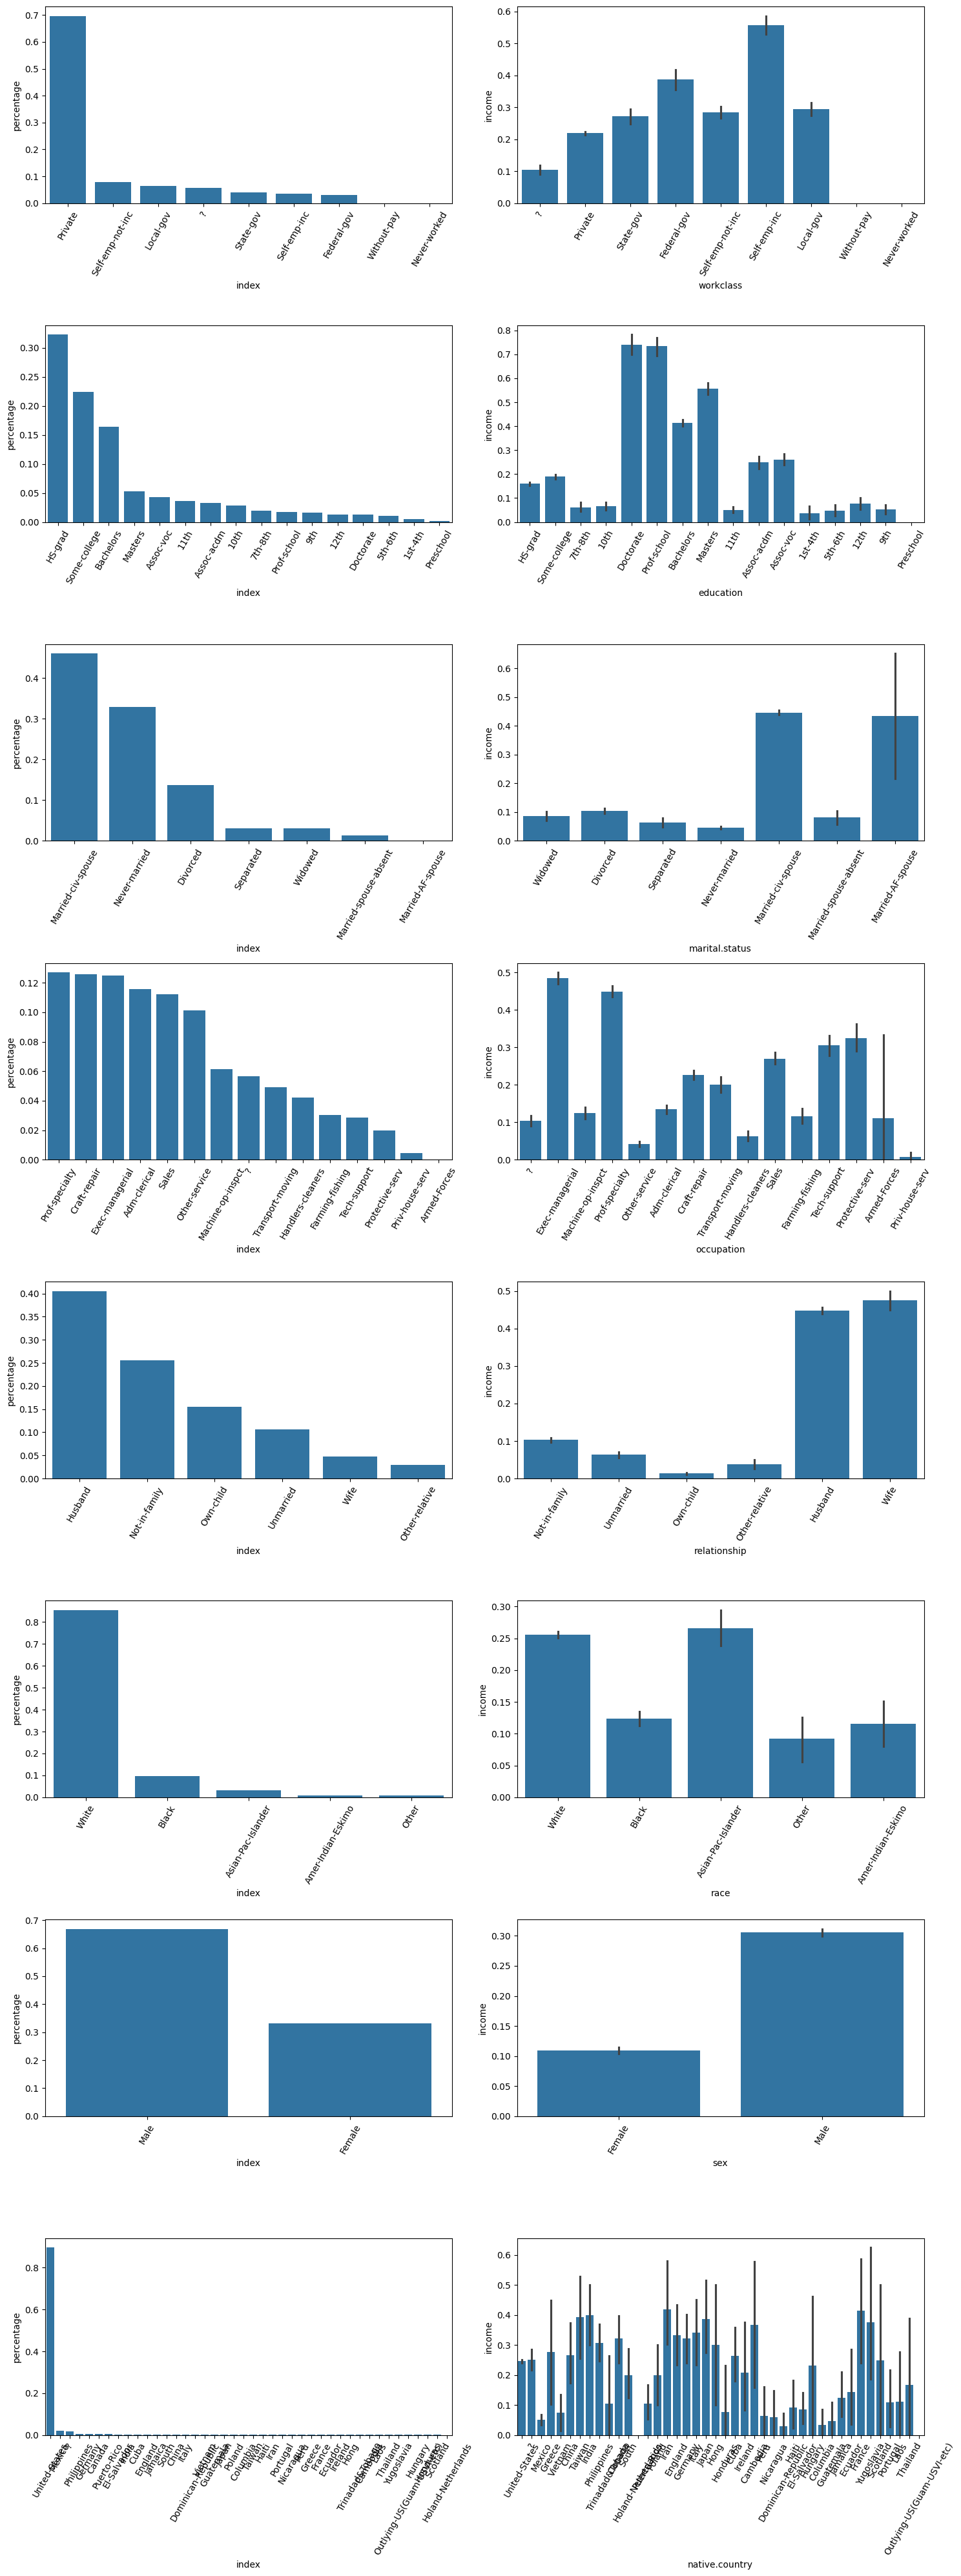

In [8]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [9]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [10]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [12]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

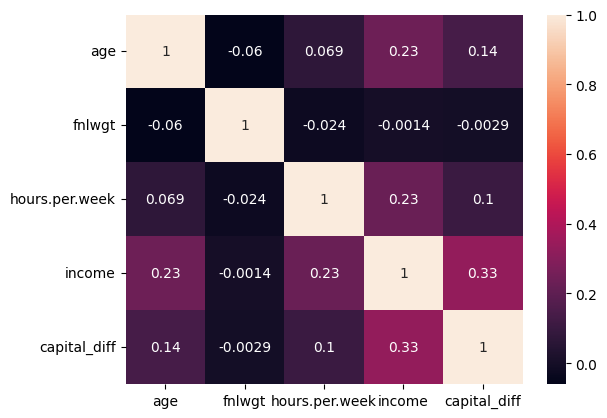

In [13]:

sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [14]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [15]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [19]:
linear_model.LogisticRegression()

LogisticRegression()

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'l1'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000,
        class_weight='balanced' #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.p

CPU times: user 1.61 s, sys: 84.2 ms, total: 1.69 s
Wall time: 7.15 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.68
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'saga'}


In [21]:
grid_param={'penalty':['l1','l2'],'solver':['lbfgs', 'saga']}
grid_sv=GridSearchCV(
    estimator=linear_model.LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ), 
    param_grid=grid_param,
    cv=5,
    n_jobs=-1

)

grid_sv.fit(X_train_scaled, y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.p

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']})

In [22]:
grid_sv.best_params_

{'penalty': 'l1', 'solver': 'saga'}

Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [23]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
               ]
grid_search_1 = GridSearchCV(scoring='f1',
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/roman/.local/lib

CPU times: user 939 ms, sys: 235 ms, total: 1.17 s
Wall time: 31.5 s
accuracy на тестовом наборе: 0.64
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.9, 'penalty': 'l2', 'solver': 'lbfgs'}


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [24]:
print(grid_search_1 .best_estimator_)

LogisticRegression(C=0.9, max_iter=1000, random_state=1)


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

In [25]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.80


In [26]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104511,0.013213,0.008934,0.002367,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.593629,0.591403,0.602262,0.606689,0.6,0.598797,0.005606,37
1,0.283794,0.024672,0.007437,0.000920,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.592664,0.590737,0.602262,0.605747,0.6,0.598282,0.005710,39


In [27]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

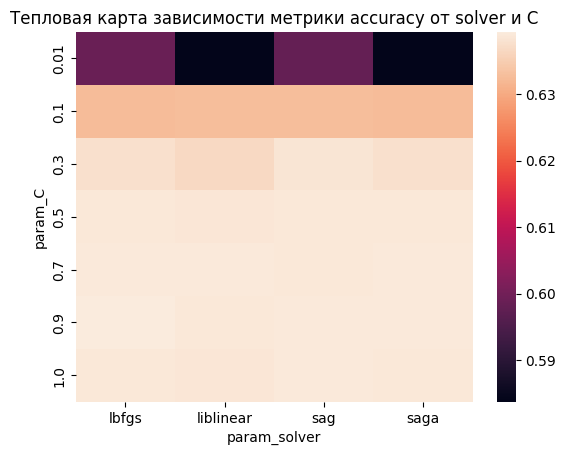

In [28]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и  алгоритмы оптимизации lbfgs и sag работают лучше.

### <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/roman/.local/lib/

CPU times: user 782 ms, sys: 25 ms, total: 807 ms
Wall time: 3.69 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.45}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [30]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))}
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring='recall'
)  
%time grid_search_2.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test_scaled, y_test)))
y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/roman/.local/li

CPU times: user 891 ms, sys: 349 ms, total: 1.24 s
Wall time: 13.8 s
accuracy на тестовом наборе: 0.58
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [31]:
grid_search_2.best_score_

0.578831595468207

#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [32]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


In [33]:
from sklearn.model_selection import learning_curve

valid_size,train_score,test_score=learning_curve(estimator=dt,
               X=X_train_scaled,
               y=y_train,
               )

In [34]:
test_score=np.mean(test_score,axis=1)
train_score=np.mean(train_score,axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


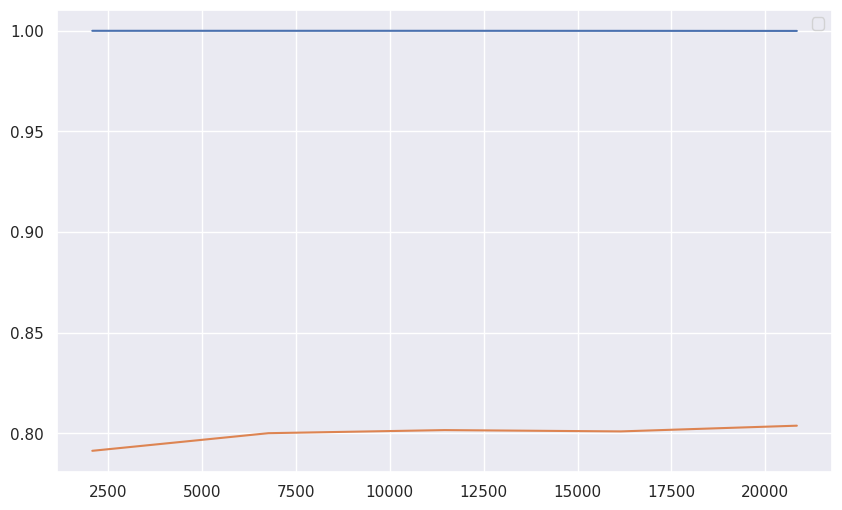

In [35]:
fg,ax=plt.subplots(figsize=(10,6))
ax.plot(valid_size,train_score)
ax.plot(valid_size,test_score)
ax.legend()

Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [36]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1,
    scoring='f1'
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: user 547 ms, sys: 66.1 ms, total: 614 ms
Wall time: 9.87 s
accuracy на тестовом наборе: 0.67
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'min_samples_leaf': 6, 'max_depth': 14, 'criterion': 'entropy'}


In [37]:
pd.DataFrame(random_search_tree.cv_results_).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.156671,0.008233,0.008391,0.001888,26,10,entropy,"{'min_samples_leaf': 26, 'max_depth': 10, 'cri...",0.633472,0.635305,0.633663,0.642982,0.635220,0.636128,0.003510,18
1,0.138220,0.010808,0.006998,0.000472,100,22,gini,"{'min_samples_leaf': 100, 'max_depth': 22, 'cr...",0.617607,0.629255,0.631866,0.641964,0.648059,0.633750,0.010551,29


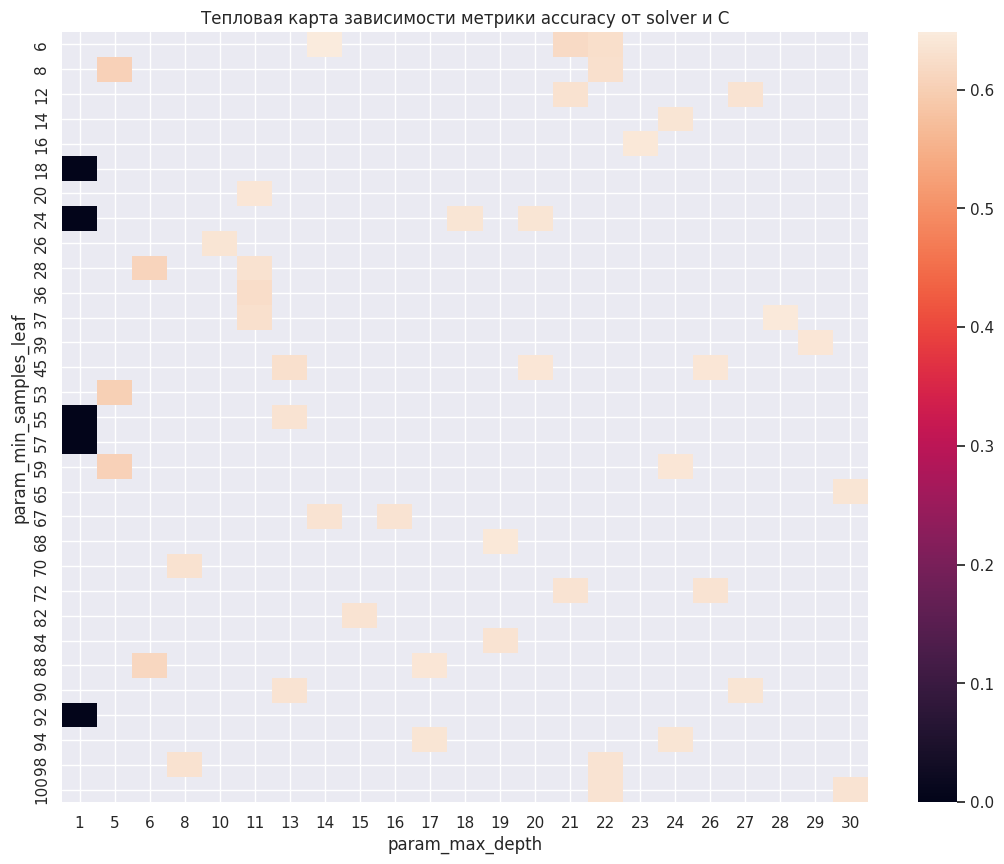

In [38]:

fig,ax=plt.subplots(figsize=(13,10))
visual = pd.pivot_table(pd.DataFrame(random_search_tree.cv_results_),
               values='mean_test_score', index='param_min_samples_leaf',
               columns='param_max_depth')
sns.heatmap(visual,ax=ax)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С'); # подпись графика
#sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Метрику удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени;

#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42,max_depth=7,min_samples_leaf=5,criterion='entropy')

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

Train: 0.60
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     19775
           1       0.82      0.47      0.60      6273

    accuracy                           0.85     26048
   macro avg       0.84      0.72      0.75     26048
weighted avg       0.84      0.85      0.83     26048

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4945
           1       0.82      0.47      0.60      1568

    accuracy                           0.85      6513
   macro avg       0.83      0.72      0.75      6513
weighted avg       0.84      0.85      0.83      6513



In [ ]:
a,b,c=learning_curve(estimator=rf,
                     X=X_train_scaled,
                     y=y_train,
                     cv=5,
                     random_state=42,
                     scoring='f1')

In [ ]:
b=np.mean(b,axis=1)
c=np.mean(c,axis=1)


/tmp/ipykernel_5620/735816163.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


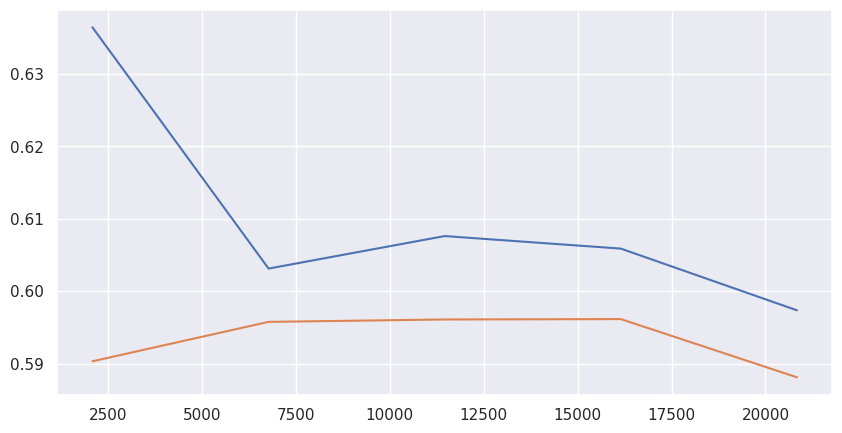

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
ax.plot(a,b)
ax.plot(a,c)
fig.show()

Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [ ]:
from sklearn.model_selection import StratifiedKFold
cvs=StratifiedKFold(n_splits=5)

In [ ]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=cvs,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
random_search_forest.predict_proba
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 2.54 s, sys: 17 ms, total: 2.56 s
Wall time: 47.1 s
f1_score на обучающем наборе: 0.72
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 24}


In [ ]:
random_search_forest.predict(X_test_scaled).shape

(6513,)

In [ ]:
pd.DataFrame(random_search_forest.cv_results_).describe().T

,count,mean,std,min,25%,50%,75%,max
mean_fit_time,10.0,3.301296,0.892508,2.039121,2.794615,3.193335,4.187198,4.287646
std_fit_time,10.0,0.244311,0.115788,0.132096,0.175840,0.220997,0.265044,0.546057
mean_score_time,10.0,0.114363,0.030526,0.071103,0.095956,0.111102,0.142506,0.154078
std_score_time,10.0,0.010286,0.005872,0.002598,0.006029,0.008848,0.013453,0.019747
split0_test_score,10.0,0.855240,0.001220,0.853359,0.854511,0.855566,0.855998,0.857006
split1_test_score,10.0,0.854530,0.001021,0.852975,0.854127,0.854319,0.854846,0.856814
split2_test_score,10.0,0.861286,0.001244,0.859309,0.860269,0.861708,0.861996,0.863148
split3_test_score,10.0,0.858860,0.000813,0.857170,0.858514,0.858994,0.859474,0.859858
split4_test_score,10.0,0.852505,0.000945,0.851027,0.851843,0.852275,0.853235,0.854099
mean_test_score,10.0,0.856484,0.000598,0.855267,0.856160,0.856496,0.857004,0.857187


In [ ]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 2.66 s, sys: 42.6 ms, total: 2.71 s
Wall time: 1min 24s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


In [ ]:
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict


In [ ]:
model=ensemble.RandomForestClassifier(max_depth=50,min_samples_leaf=5,random_state=42)
model.fit(X_train_scaled,y=y_train)
cvs=StratifiedKFold(n_splits=5)

cv_metrics=cross_validate(estimator=model,
               X=X_train_scaled,
               y=y_train,
               cv=cvs,
               scoring='f1',
               return_train_score=True
)


In [ ]:
cv_metrics

{'fit_time': array([1.916682  , 1.89928055, 2.0967648 , 2.11816216, 1.9559195 ]),
 'score_time': array([0.06817079, 0.06752872, 0.06906557, 0.06729078, 0.07400632]),
 'test_score': array([0.65101289, 0.65185857, 0.67334852, 0.6642369 , 0.65029559]),
 'train_score': array([0.72295693, 0.72739587, 0.71879256, 0.71912668, 0.72543909])}

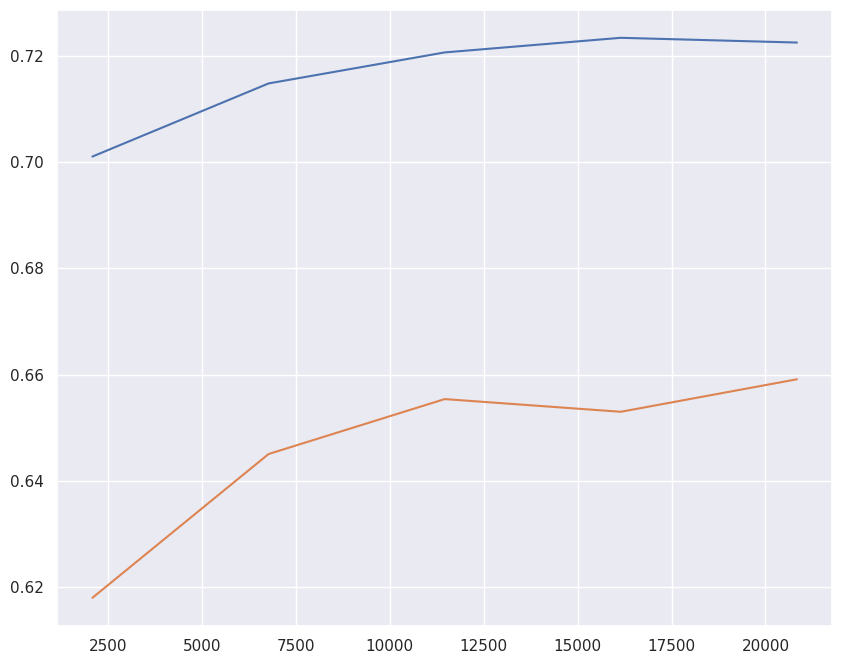

In [ ]:
a,b,c=learning_curve(estimator=model,
                    X=X_train_scaled,
                    y=y_train,
                    cv=cvs,
                    scoring='f1'
)

b=np.mean(b,axis=1)
c=np.mean(c,axis=1)
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(a,b)
ax.plot(a,c)

In [ ]:
predict=cross_val_predict(estimator=model,
                        X=X_train_scaled,
                        y=y_train,
                        cv=cvs,
                        method='predict_proba')

In [ ]:
predict

array([[0.97979362, 0.02020638],
       [0.76343048, 0.23656952],
       [0.89500153, 0.10499847],
       ...,
       [0.83355613, 0.16644387],
       [0.99368325, 0.00631675],
       [0.90959575, 0.09040425]])

In [ ]:
predict_proba=random_search_forest.predict_proba(X_test_scaled)[:,1]
predict_proba.shape

(6513,)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold=precision_recall_curve(y_train_,predict_proba)

NameError: name 'y_train_' is not defined

In [ ]:
precision_recall_curve(y_train,predict_proba)

(array([0.24082463, 0.24112085, 0.24114866, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.18826718e-04, 1.59413359e-04, 0.00000000e+00]),
 array([0.00000000e+00, 2.05338809e-05, 2.05761317e-05, ...,
        9.84039576e-01, 9.85615717e-01, 9.88033009e-01]))

18530
0.7012166949022024 0.3784193348966713


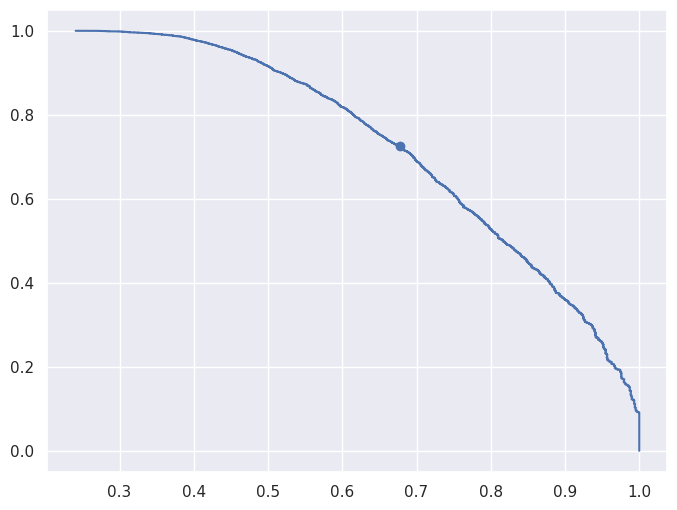

In [ ]:
f1_scores = (2 * precision * recall) / (precision + recall)
idx=np.argmax(f1_scores)
print(idx)
print(f1_scores[idx],threshold[idx])

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(precision,recall)
ax.scatter(precision[idx],recall[idx],marker='o');

In [ ]:
predict_X=cross_val_predict(estimator=model,
                        X=X_train_scaled,
                        y=y_train,
                        cv=cvs)

In [ ]:
len(predict_proba)

26048

In [ ]:
threshold=0.38
predict_proba_new=(predict_proba>threshold).astype('int')
predict_proba_new.sum()

6685

In [ ]:
metrics.f1_score(y_train,predict_proba_new)

0.7007254205895972

In [ ]:
threshold=0.39

predict_test=model.predict_proba(X_test)[:,1]
predict_test=(predict_test>threshold).astype('int')
metrics.f1_score(y_test,predict_test)

/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.635335511435034

In [ ]:
cross_test=cross_val_predict(estimator=model,
                             X=X_test,
                             y=y_test,
                             cv=cvs,
)



In [ ]:
f1=(2*recesion*recall)/(recesion+recall)

idx=np.argmax(threshold)

print(f1[idx],threshold[idx])

0.000318775900541919 0.9889097537507728


In [ ]:
model=ensemble.RandomForestClassifier(random_state=42)
param_dist={'n_estimators':list(range(100,200,30)),
            'min_samples_leaf':[5, 7],
            'max_depth':[10, 15, 20, 25]  }
selector=RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_jobs=-1,
    n_iter=10,
    cv=5)

In [ ]:
selector.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, 20, 25],
                                        'min_samples_leaf': [5, 7],
                                        'n_estimators': [100, 130, 160, 190]},
                   scoring='f1_weighted')

In [ ]:
predict=selector.predict(X_test_scaled)

In [ ]:
metrics.f1_score(y_test,predict).round(2)

0.68

In [ ]:
pd.DataFrame(selector.cv_results_)

In [ ]:
model_new=ensemble.RandomForestClassifier(random_state=42)
param_dist={'n_estimators':list(range(99,200,30)),
            'min_samples_leaf':[5, 7],
            'max_depth':[10, 15, 20, 25]  }
selector_new=GridSearchCV(
    estimator=model_new,
    param_grid=param_dist,
    n_jobs=-1,
    cv=5)

In [ ]:
selector_new.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [5, 7],
                         'n_estimators': [99, 129, 159, 189]})

In [ ]:
predict_gs=selector_new.predict(X_test_scaled)
metrics.f1_score(y_test,predict_gs)

0.6764275256222547

Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

#### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

### <center> Hyperopt

In [ ]:
# Устанавливаем библиотеку
# !pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

In [40]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [41]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [42]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])}
              
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [43]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=25, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 25/25 [01:36<00:00,  3.85s/trial, best loss: -0.7784334763948498]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}
CPU times: user 1min 35s, sys: 0 ns, total: 1min 35s
Wall time: 1min 36s


In [44]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.78
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [45]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

25trial [00:00, ?trial/s, best loss=?]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

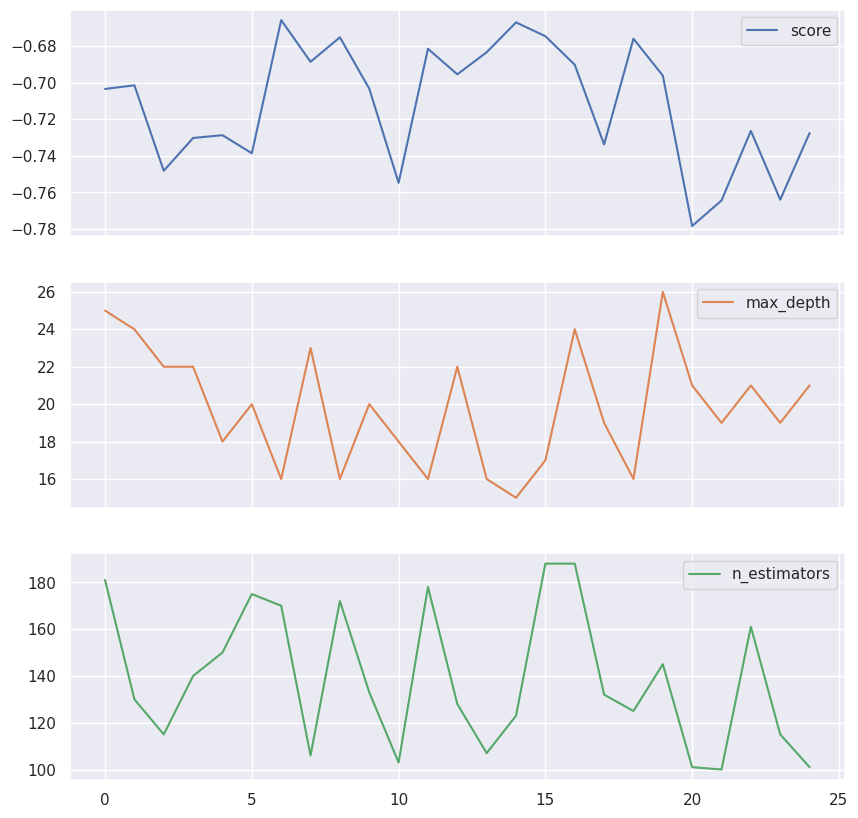

In [46]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [47]:
space={'n_estimators': hp.quniform('n_estimators',100,300,10),
       'min_samples':hp.quniform('min_samples',3,7,1),
       'max_depth':hp.quniform('max_depth',15,40,1)}

In [48]:
best=fmin(hyperopt_rf,
          space=space,
          max_evals=20,
          trials=trials,
          rstate=np.random.default_rng(random_state))
print(best)

model=ensemble.RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

TPE is being used as the default algorithm.


25trial [00:00, ?trial/s, best loss=?]
{'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}
f1_score на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67


По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [ ]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [49]:
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.1


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [50]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [51]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-09-04 15:33:49,012] A new study created in memory with name: RandomForestClassifier
/tmp/ipykernel_8527/2452349367.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
/tmp/ipykernel_8527/2452349367.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
/tmp/ipykernel_8527/2452349367.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2024-09-04 15:33:52,425] Trial 0 finished with value: 0.6902233614060783 and parameters: {'n_estimators': 113, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.6902233614060783.
/tmp/ipykernel_8527/2452349367.py:3:

CPU times: user 1min 32s, sys: 59.8 ms, total: 1min 32s
Wall time: 1min 32s


In [52]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 166, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.80


In [53]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


In [54]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

/tmp/ipykernel_8527/2452349367.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
/tmp/ipykernel_8527/2452349367.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
/tmp/ipykernel_8527/2452349367.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2024-09-04 15:35:53,913] Trial 20 finished with value: 0.7732041969330105 and parameters: {'n_estimators': 147, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 18 with value: 0.7996102055279943.
/tmp/ipykernel_8527/2452349367.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected 

CPU times: user 37.4 s, sys: 23.2 ms, total: 37.4 s
Wall time: 37.5 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [55]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [56]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [57]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [58]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с синим фоном это и есть лучшии комбинации n_estimator, max_depth.
















In [60]:
def optuna_new(trials):
    n_estimators=trials.suggest_int('n_estimators',100,300,10)
    min_samples_leaf=trials.suggest_int('min_samples_leaf',3,7,1)
    max_depth=trials.suggest_int('max_depth',15,40,1)
    
    model=ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          min_samples_leaf=min_samples_leaf,
                                          max_depth=max_depth)
    model.fit(X_train_scaled, y_train)
    score=metrics.f1_score(y_train,model.predict(X_train_scaled)) 
    return score
study=optuna.create_study(study_name='RandomForestClassifier',direction='maximize')
study.optimize(optuna_new,n_trials=20)   

[I 2024-09-04 15:51:03,372] A new study created in memory with name: RandomForestClassifier
/tmp/ipykernel_8527/1958632175.py:2: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

/tmp/ipykernel_8527/1958632175.py:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

/tmp/ipykernel_8527/1958632175.py:4: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-09-04 15:51:06,930] Trial 0 finished with value: 0.7128461189287335 and parameters: {'n_estimators': 120, 'min_samples_leaf': 6, 'max_depth': 40}. Best is trial 0 with value: 0.7128461189287335.
/tmp/ipykernel_8527/1958632175.py:2: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

/tmp/ipykernel_8527/1958632175.py:3: FutureWarning:

sugg

In [61]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 37}
f1_score на обучающем наборе: 0.77
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
